Problem 1

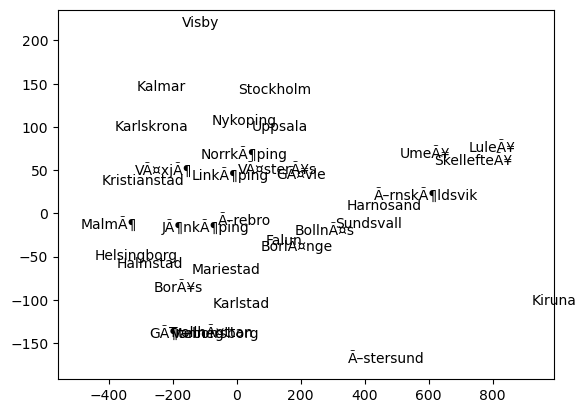

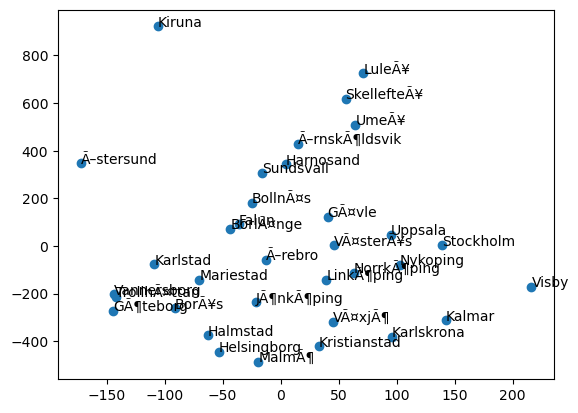

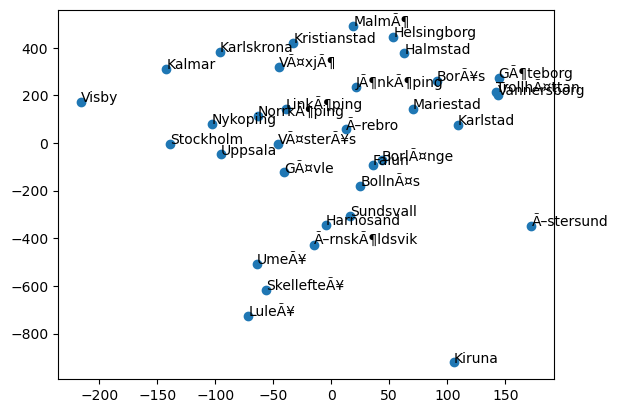

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#B = np.genfromtxt('data/city-inner-sweden.csv', delimiter=' ')
D = np.genfromtxt('Lab5/city-distances-sweden.csv', delimiter=' ')
names = np.genfromtxt('Lab5/city-names-sweden.csv', delimiter='\n', dtype=str)

# double centering to obtain B matrix
n = D.shape[0]
J = np.eye(n) - (1/n) * np.ones((n, n))
B = - 0.5 * np.matmul(np.matmul(J, D**2), J)

# eigen decomposition
e_val, e_vec = np.linalg.eig(B)
idx = e_val.argsort()[::-1]
e_val = e_val[idx]
e_vec = e_vec[:, idx]

# reduce to k dimensions
k = 2
Z_k = np.matmul(e_vec[:, :k], np.diag(np.sqrt(e_val[:k])))


# plot result
plt.figure()
plt.scatter(Z_k[:, 0], Z_k[:, 1], c='white')
for i, city in enumerate(names):
    plt.annotate(city, Z_k[i, :]) #, size=20)

plt.figure()
plt.scatter(Z_k[:, 1], Z_k[:, 0])
for i, city in enumerate(names):
    plt.annotate(city, [Z_k[i, 1], Z_k[i, 0]])

plt.figure()
plt.scatter(-Z_k[:, 1], -Z_k[:, 0])
for i, city in enumerate(names):
    plt.annotate(city, [-Z_k[i, 1], -Z_k[i, 0]])


Problem 2

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

data = np.genfromtxt('Lab5/auto-mpg.csv', delimiter=' ')
y = data[:, 0]  # response
X = data[:, 1:]  # predictor variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

class Linreg(object):
    def __init__(self):
        self.w = None

    def train(self, x, y):
        x = np.hstack((np.ones((len(y), 1)), x))
        self.w = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)

    def test(self, x):
        x = np.hstack((np.ones((x.shape[0], 1)), x))
        return np.matmul(x, self.w)

# function to perform forward selection (w/ cv)
def forward_selection(X_train, y_train):

    n_features = X_train.shape[1]
    selected_features = []
    best_r2 = -np.inf

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    while True:
        best_feature = None
        for i in range(n_features):

            if i in selected_features:
                continue

            current_features = selected_features + [i]   # We add one in the feature range indexes

            reg = Linreg()
            reg.train(X_train[:, current_features], y_train)
            pred = reg.test(X_val[:, current_features])

            # relative square error
            Erse = np.sum((y_val - pred) ** 2) / np.sum((y_val - np.mean(y_val)) ** 2)
            r2 = 1 - Erse

            if r2 > best_r2:
                best_r2 = r2
                best_feature = i

        if best_feature is not None:
            selected_features.append(best_feature)
        else:
            break

    return selected_features


# all features
reg = Linreg()
reg.train(X_train, y_train)
pred_all = reg.test(X_test)

Erse = np.sum((y_test - pred_all) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
r2_all = 1 - Erse
print('all features, R2 = ', r2_all)

# reduce features
selected_features = forward_selection(X_train, y_train)
reg = Linreg()
reg.train(X_train[:, selected_features], y_train)
pred_subset = reg.test(X_test[:, selected_features])

Erse = np.sum((y_test - pred_subset) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
r2_subset = 1 - Erse
print('best subset: ', selected_features, 'R2 = ', r2_subset)



all features, R2 =  0.7929585235796173
best subset:  [3, 5, 0] R2 =  0.7933313716522798


2d

In [5]:
def forward_selection_cv(X_train, y_train, n_splits=10):

    n_features = X_train.shape[1]
    selected_features = []
    best_r2 = -np.inf
    kf = KFold(n_splits)

    while True:
        best_feature = None
        for i in range(n_features):

            if i in selected_features:
                continue

            current_features = selected_features + [i]
            r2 = 0

            # cv for current features
            for train_index, val_index in kf.split(X_train):
                X_t = X_train[train_index]
                y_t = y_train[train_index]
                X_v = X_train[val_index]
                y_v = y_train[val_index]

                reg = Linreg()
                reg.train(X_t[:, current_features], y_t)
                pred = reg.test(X_v[:, current_features])

                # relative square error
                Erse = np.sum((y_v-pred) ** 2) / np.sum((y_v - np.mean(y_v)) ** 2)
                r2 += (1 / n_splits) * (1 - Erse)

            if r2 > best_r2:
                best_r2 = r2
                best_feature = i

        if best_feature is not None:
            selected_features.append(best_feature)
        else:
            break

    return selected_features

# reduce features (w/ cv)
selected_features = forward_selection_cv(X_train, y_train)
reg = Linreg()
reg.train(X_train[:, selected_features], y_train)
pred_subset = reg.test(X_test[:, selected_features])

Erse = np.sum((y_test - pred_subset) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
r2_subset_cv = 1 - Erse
print('best subset (cv): ', selected_features, 'R2 = ', r2_subset_cv)

best subset (cv):  [3, 5] R2 =  0.7984389072537443
